<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales I-2018 </h1>

<H3 align='center'> Tarea 2 - Redes Neuronales Convolucionales y Recurrentes </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Regularización en Redes Convolucionales.
* Diseño e implementación de redes recurrentes (RNN) usando keras.
* Diseño y entrenamiento de autoencoders (AEs)
* Transfer Learning, pre-entrenamiento (*fine tunning*).
 

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 1 y 4 de Junio.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea2-INF395-I-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Entrenamiento de RNNs en una Serie de Tiempo    
[2.](#segundo) Redes recurrentes sobre texto  
[3.](#tercero) Autoencoders (AEs) en MNIST  
[4.](#cuarto) Transfer Learning

*Nota: Para esta actividad si es que no se cuenta con GPU se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__*


<a id="primero"></a>
## 1. Entrenamiento de RNNs en una Serie de Tiempo
En esta sección emplearemos redes neuronales recurrentes para modelar series de tiempo, es decir una serie
de registros (tı́picamente valores reales) regularmente indexados en el tiempo. Para ello utilizaremos un dataset
denominado "*Minimum Daily Temperatures*", el cual describe la temperatura mínima diaria en un período de 10 años (1981 a 1990) en la ciudad de Melbourne, Australia. Las unidades de las 3670 observaciones fueron medidas en grados celsius. A continuación se muestra la secuencia de tiempo:
<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/11/Minimum-Daily-Temperatures.png" width="60%" />



La tarea predictiva consiste en estimar la temperatura mínima diaria de algún día basado en la información de días anteriores.  
*La fuente es acreditada a Australian Bureau of Meteorology.*

> a) Escriba una función que cargue los datos, los divida en 1500 de entrenamiento y el resto (500) de pruebas. Además de esto escálelos apropiadamente para trabajar con redes recurrentes.  
```python
name_f = "time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:2000]
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[:1500].values, dataframe[1500:].values
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)
```



In [2]:
import pandas as pd

name_f = "time_series_data.csv"
dataframe = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[:2000]
print ("\nLas dimensiones del dataframe de trabajo son:",dataframe.shape)
print ("\n\nA modo de ejemplo, e presentan los primeros registros del dataframe:\n",dataframe.head())
print ("\n\nEn resumen, se tien un dataframe con las siguientes características:\n",dataframe.describe())



Las dimensiones del dataframe de trabajo son: (2000, 1)


A modo de ejemplo, e presentan los primeros registros del dataframe:
    Daily minimum temperatures in Melbourne, Australia, 1981-1990
0                                               20.7            
1                                               17.9            
2                                               18.8            
3                                               14.6            
4                                               15.8            


En resumen, se tien un dataframe con las siguientes características:
        Daily minimum temperatures in Melbourne, Australia, 1981-1990
count                                        2000.000000            
mean                                           11.148250            
std                                             4.194983            
min                                             0.000000            
25%                                             8.100000        

In [3]:
dataframe[:] = dataframe[:].astype('float32')
df_train, df_test = dataframe[:1500].values, dataframe[1500:].values
print ("Las dimensiones del conjunto de entrenamiento son:",df_train.shape)
print ("Las dimensiones del conjunto de pruebas son:",df_test.shape)

Las dimensiones del conjunto de entrenamiento son: (1500, 1)
Las dimensiones del conjunto de pruebas son: (500, 1)


In [4]:
#al no tener conocimiento del dominio del problema se prefiere escalalr los datos, aunque 
#al parecer no hay gran varianza o diferencia de rangos de valores entre los registros a manipular
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1)).fit(df_train)
stream_train_scaled = scaler.transform(df_train)
stream_test_scaled = scaler.transform(df_test)

print ("Nuevo mínimo: ", np.min(stream_train_scaled))
print ("Nuevo máximo: ",np.max(stream_train_scaled))

Nuevo mínimo:  0.0
Nuevo máximo:  1.0


In [4]:
#parece que sí cambiaron bastante. Esto se debe al método de escalado minmax

> b) Ahora nos gustarı́a manipular los datos, para que hagamos la predicción de la temperatura mínima para el tiempo siguiente usando la temperatura mínima de los últimos perı́odos de tiempo. El número de perı́odos de tiempos que usaremos se denomina *lag*. Por ejemplo, tendremos un *lag* igual a 3, si para predecir el valor $x_{t+1}$ en el tiempo siguiente usamos la información del tiempo actual $x_t$ y la de los dos perı́odos anteriores $x_{t-1}$ y $x_{t-2}$ como variables de entrada. Realice una función que reciba una secuencia de valores y la transforme en dos arreglos *dataX* (inputs) y *dataY* (targets) donde el número de caracterı́sticas de la la matriz de entrada (columnas) sea el número de tiempos que se considerarán como información (*lag*).
```python
def create_dataset(dataset,lag=1):
    return np.array(dataX),np.array(dataY)
```
Por ejemplo si en el dataset tenemos el arreglo 20.7,17.9,18.8,14.6,15.8,15.8,10.1.
```python
create_dataset(dataset,3)
```
La función debiese generar $(X_1,X_2,X_3)$ e $Y$:


|X0|X1|X2|Y|
|---|---|---|---|
|20.7|17.9|18.8|14.6|
|17.9|18.8|14.6|15.8|
|18.8|14.6|15.8|15.8|
|14.6|15.8|15.8|10.1|




In [5]:
"""
b) Ahora nos gustarı́a manipular los datos, para que hagamos la predicción de la temperatura mínima 
para el tiempo siguiente usando la temperatura mínima de los últimos perı́odos de tiempo. El número de 
perı́odos de tiempos que usaremos se denomina lag. Por ejemplo, tendremos un lag igual a 3, si para 
predecir el valor  xt+1xt+1  en el tiempo siguiente usamos la información del tiempo actual  xtxt  y
la de los dos perı́odos anteriores  xt−1xt−1  y  xt−2xt−2  como variables de entrada. Realice una 
función que reciba una secuencia de valores y la transforme en dos arreglos dataX (inputs) y 
dataY (targets) donde el número de caracterı́sticas de la la matriz de entrada (columnas) sea el número
de tiempos que se considerarán como información (lag).
"""
import numpy as np
def create_dataset(dataset,lag=1):
    dataY=dataset[lag:]
    dataX=[]
    for i in range(len(dataY)):
        dataX.append(dataset[i:lag+i])
    return np.array(dataX),np.array(dataY)

dataset=[20.7,17.9,18.8,14.6,15.8,15.8,10.1]

X,Y=create_dataset(dataset,3)
print("Matriz X\n",X)
print("Matriz Y\n",Y)


Matriz X
 [[20.7 17.9 18.8]
 [17.9 18.8 14.6]
 [18.8 14.6 15.8]
 [14.6 15.8 15.8]]
Matriz Y
 [14.6 15.8 15.8 10.1]


> c) Usando la función anterior genere los conjuntos de entrenamiento y test para el problema.
```python
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
```



In [6]:
"""
c) Usando la función anterior genere los conjuntos de entrenamiento y test para el problema.
"""
lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)


In [7]:

print ("Las dimensiones del conjunto X de entrenamiento son:",trainX.shape)
print ("Las dimensiones del conjunto Y de entrenamiento son:",trainY.shape)

print ("Las dimensiones del conjunto X de pruebas son:",testX.shape)
print ("Las dimensiones del conjunto Y de pruebas son:",testY.shape)

Las dimensiones del conjunto X de entrenamiento son: (1497, 3, 1)
Las dimensiones del conjunto Y de entrenamiento son: (1497, 1)
Las dimensiones del conjunto X de pruebas son: (497, 3, 1)
Las dimensiones del conjunto Y de pruebas son: (497, 1)


> d) En estos momentos tenemos nuestros datos en la forma [ejemplos, atributos]. Sin embargo, la red LSTM necesita que los datos se encuentren en un arreglo de tres dimensiones [*samples, time steps, features*]. Transforme el  train y test sets a la estructura deseada.
```python
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
```



In [8]:
"""
d) En estos momentos tenemos nuestros datos en la forma [ejemplos, atributos].
Sin embargo, la red LSTM necesita que los datos se encuentren en un arreglo de 
tres dimensiones [samples, time steps, features]. Transforme el train y test 
sets a la estructura deseada.
"""
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(trainX)
#time steps corresponde a las veces que samples se usará para la predicción 
#es 1, samples es el conjunto de datos

(1497, 1, 3)
[[[0.7870723 0.6806084 0.7148289]]

 [[0.6806084 0.7148289 0.5551331]]

 [[0.7148289 0.5551331 0.6007605]]

 ...

 [[0.7224335 0.5969582 0.6844107]]

 [[0.5969582 0.6844107 0.5627377]]

 [[0.6844107 0.5627377 0.5285171]]]


> e) Entrene una LSTM usando un lag de 3
```python
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
```



In [9]:
"""
e) Entrene una LSTM usando un lag de 3
"""
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
model = Sequential()
model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
print (model.summary())

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", recurrent_activation="sigmoid", input_shape=(None, 3))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 133
Trainable params: 133
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
##qué son los bloques??? 
# units: Positive integer, dimensionality of the output space.

In [11]:
import os, time
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo= model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

Epoch 1/25
1497/1497 [==============================] - 13s 9ms/step - loss: 0.0182
Epoch 2/25
1497/1497 [==============================] - 11s 8ms/step - loss: 0.0106
Epoch 3/25
1497/1497 [==============================] - 11s 8ms/step - loss: 0.0104
Epoch 4/25
1497/1497 [==============================] - 11s 8ms/step - loss: 0.0102
Epoch 5/25
1497/1497 [==============================] - 11s 8ms/step - loss: 0.0102
Epoch 6/25
1497/1497 [==============================] - 11s 8ms/step - loss: 0.0101
Epoch 7/25
1497/1497 [==============================] - 11s 7ms/step - loss: 0.0101
Epoch 8/25
1497/1497 [==============================] - 11s 8ms/step - loss: 0.0100
Epoch 9/25
1497/1497 [==============================] - 11s 8ms/step - loss: 0.0100
Epoch 10/25
1497/1497 [==============================] - 11s 7ms/step - loss: 0.0100
Epoch 11/25
1497/1497 [==============================] - 11s 7ms/step - loss: 0.0100
Epoch 12/25
1497/1497 [==============================] - 11s 7ms/step - lo

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(histo.history['loss'],label="Loss")
plt.title("Error durante el entrenamiento")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()


<Figure size 1000x600 with 1 Axes>

> f) Realice las predicciones del modelo para los conjuntos de entrenamiento y prueba. Denormalice los datos para que el error pueda ser computado en la escala original.
```python
trainPredict = model.predict(trainX,batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainP)
trainY = scaler.inverse_transform([trainY])
```



In [9]:

batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())


NameError: name 'model' is not defined

> g) Compute el *root mean square error* (RMSE) sobre los conjuntos de entrenamiento y test, comente.

```python
from sklearn.metrics import mean_squared_error
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
```



In [14]:
import math
from sklearn.metrics import mean_squared_error
trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 2.61 RMSE
Test Score: 2.41 RMSE


> h) Grafique las predicciones del train y test set, y contrástelas con la serie de tiempo original. Muestre un extracto de la predicción para ver en mas detalle cómo es la predicción, comente.

```python
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredic
```



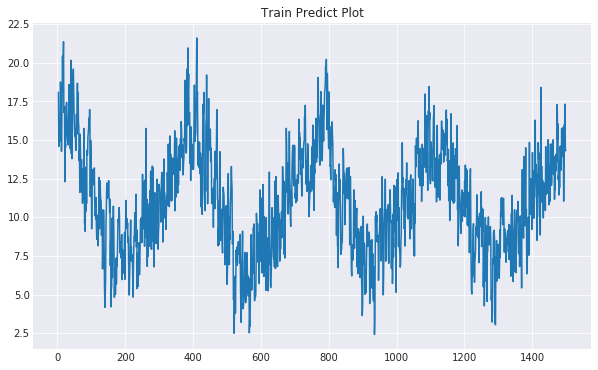

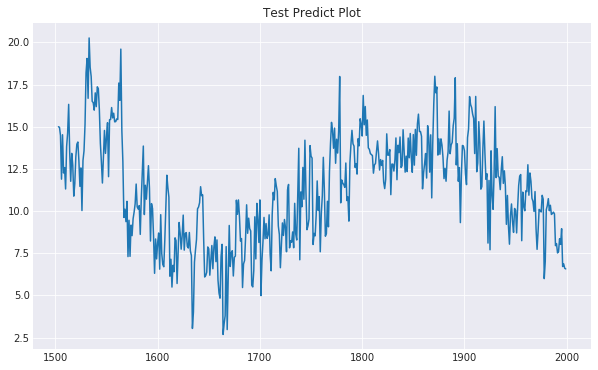

In [15]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(18, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
sns.set_style("darkgrid")
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
sns.set_style("darkgrid")

plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'g', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo")
plt.legend(loc="upper right")
plt.show()

> i) En lugar de aumentar el número de dimensiones como el el paso e), entrene la red con un *timestep* de 3 (con dimensión de entrada 1). ¿Se produce una mejora del error de entrenamiento y pruebas? ¿Los tiempos de computación son comparables? Comente brevemente sobre cual es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e).
```python
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
model = Sequential()
model.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
```



In [10]:
#trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
trainX = np.reshape(trainX, (trainX.shape[0], 3, 1))

In [17]:
model = Sequential()
model.add(LSTM(4, input_dim=1, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1))

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  from ipykernel import kernelapp as app
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", recurrent_activation="sigmoid", input_shape=(None, 1))`
  from ipykernel import kernelapp as app


In [18]:
import os,time
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo2=model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

Epoch 1/25
1497/1497 [==============================] - 17s 11ms/step - loss: 0.0263
Epoch 2/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0122
Epoch 3/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0117
Epoch 4/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0114
Epoch 5/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0108
Epoch 6/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0106
Epoch 7/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0105
Epoch 8/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0105
Epoch 9/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0104
Epoch 10/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0104
Epoch 11/25
1497/1497 [==============================] - 16s 11ms/step - loss: 0.0103
Epoch 12/25
1497/1497 [==============================] - 16s 11

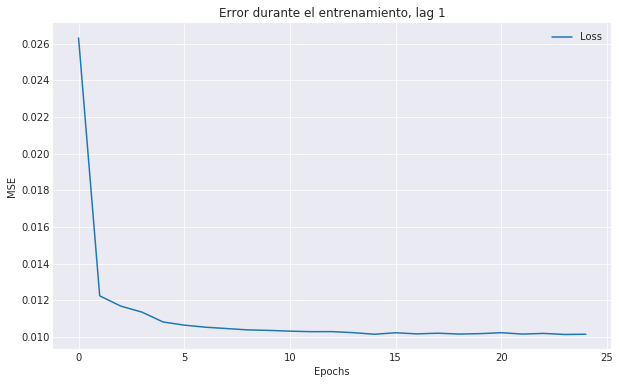

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(histo2.history['loss'],label="Loss")
plt.title("Error durante el entrenamiento, lag 1")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [20]:
batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())


In [21]:
testX = np.reshape(testX, (testX.shape[0], 3, 1))
testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

In [22]:
trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 2.64 RMSE
Test Score: 2.44 RMSE


In [24]:
##leve empeoramiento, se considera que lag 3 es mejor 

#el lag 1 tardó 436
#el lag 3 tardó 298

### LSTM, unidades variables

> j) Determine el parámetro del número de bloques para la LSTM de la pregunta e) o i), lo que le parezca mas sensato en base a lo analizado en la pregunta anterior. Utilice 5-fold *cross validation*, o bien, en su defecto, los datos restante no utilizados ni como entrenamiento ni como pruebas (los de índice 2000 hacia adelante) como conjunto fijo de validación. Comente.
```python
nb = range(4,13,2)
model = Sequential()
model.add(LSTM(nb=range(4,13,2),input_dim=choose,activation='tanh',inner_activation='sigmoid'))
model.add(Dense(1))
```



In [23]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(trainX)

(1497, 1, 3)
[[[0.7870723 0.6806084 0.7148289]]

 [[0.6806084 0.7148289 0.5551331]]

 [[0.7148289 0.5551331 0.6007605]]

 ...

 [[0.7224335 0.5969582 0.6844107]]

 [[0.5969582 0.6844107 0.5627377]]

 [[0.6844107 0.5627377 0.5285171]]]


In [25]:
from sklearn.model_selection import KFold
nb=list(np.arange(4,13,2))
lag=3     #el mejor según lo experimentado antes (probar con lag 2 (?)) --> se hace en la sig.pregunta xd

for unidades in nb:                                                                    
    kf = KFold(n_splits=5)
    errores = []
    tiempos = []
    for train, val in kf.split(trainX):#por cada fold
        model = Sequential()
        model.add(LSTM(4, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
        model.add(Dense(1,activation='linear'))
        inicio = time.time()
        model.compile(loss='mean_squared_error', optimizer='adam')
        histo= model.fit(trainX[train], trainY[train], epochs=25, batch_size=1, verbose=0)
    
        trans=(time.time() - inicio )
        print("Tiempo que requirió el entrenamiento del kfold:",trans)
        tiempos.append(trans) 
        
        batch_size=1  
        trainPredict = model.predict(trainX[val], batch_size=batch_size)
        trainPredict = scaler.inverse_transform(trainPredict) 
        trainY_ds = scaler.inverse_transform(trainY[val].copy())
        error= np.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))  
        errores.append(error)       
        
    print("Loss con", unidades,"bloques:",np.mean(errores),"en",np.mean(tiempos),"segundos") 
    

    

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(4, activation="tanh", recurrent_activation="sigmoid", input_shape=(None, 3))`


Tiempo que requirió el entrenamiento del kfold: 221.07142114639282
Tiempo que requirió el entrenamiento del kfold: 221.31065034866333
Tiempo que requirió el entrenamiento del kfold: 222.25973320007324
Tiempo que requirió el entrenamiento del kfold: 222.4410388469696
Tiempo que requirió el entrenamiento del kfold: 223.7360966205597
Loss con 4 bloques: 2.6475213 en 222.16378803253173 segundos
Tiempo que requirió el entrenamiento del kfold: 223.6213002204895
Tiempo que requirió el entrenamiento del kfold: 223.83300971984863
Tiempo que requirió el entrenamiento del kfold: 224.71107649803162
Tiempo que requirió el entrenamiento del kfold: 224.68375992774963
Tiempo que requirió el entrenamiento del kfold: 225.25638270378113
Loss con 6 bloques: 2.644836 en 224.4211058139801 segundos
Tiempo que requirió el entrenamiento del kfold: 225.66678953170776
Tiempo que requirió el entrenamiento del kfold: 226.31643891334534
Tiempo que requirió el entrenamiento del kfold: 226.40388822555542
Tiempo que r

In [29]:
##el mejor fue con 12 unidades, entrenar red con 12 y mostrar el error sobre test (lag 3)

lag = 3
trainX, trainY = create_dataset(stream_train_scaled, lag)
testX, testY = create_dataset(stream_test_scaled, lag)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
model = Sequential()
model.add(LSTM(12, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
print (model.summary())
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo= model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=1)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

(1497, 1, 3)


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(12, activation="tanh", recurrent_activation="sigmoid", input_shape=(None, 3))`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 12)                768       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 13        
Total params: 781
Trainable params: 781
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
1497/1497 [==============================] - 15s 10ms/step - loss: 0.0180
Epoch 2/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0110
Epoch 3/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0105
Epoch 4/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0104
Epoch 5/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0104
Epoch 6/25
1497/1497 [==============================] - 12s 8ms/step - loss: 0.0103
Epoch 7/25
1497/1497 [========

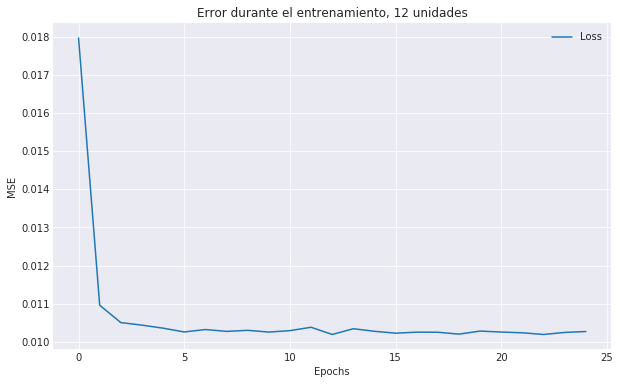

Train Score: 2.63 RMSE
Test Score: 2.42 RMSE


In [30]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(histo.history['loss'],label="Loss")
plt.title("Error durante el entrenamiento, 12 unidades")
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()


batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


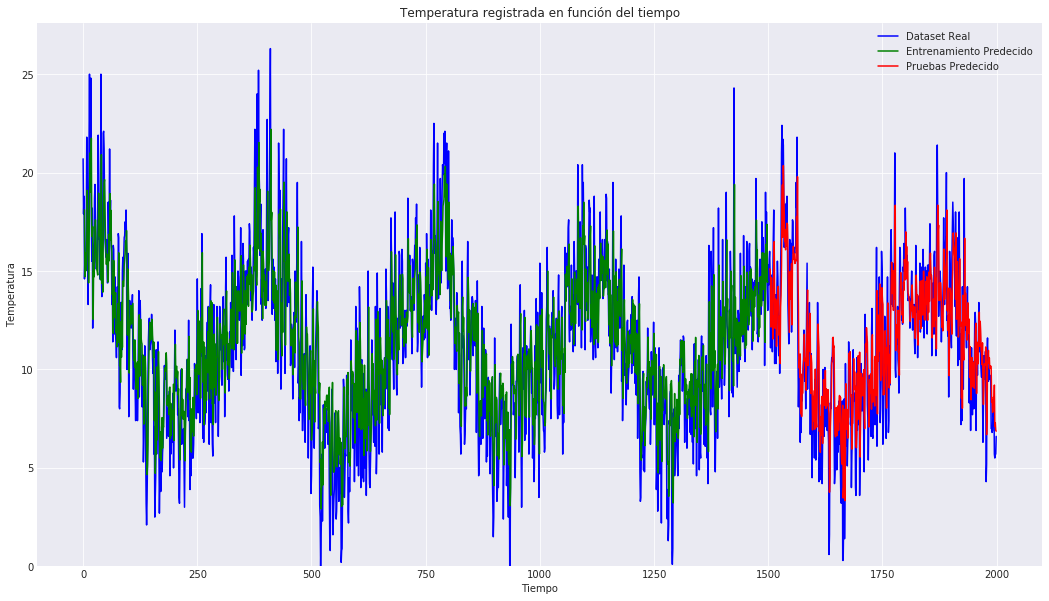

In [37]:
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(18, 10))
trainPredictPlot = np.empty_like(dataframe.values)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lag:len(trainPredict)+lag, :] = trainPredict
sns.set_style("darkgrid")
testPredictPlot = np.empty_like(dataframe.values)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict)+2*lag):, :] = testPredict
sns.set_style("darkgrid")

plt.plot(dataframe.values,'b', label = "Dataset Real")
plt.plot(trainPredictPlot,'g', label= "Entrenamiento Predecido")
plt.plot(testPredictPlot,'r', label= "Pruebas Predecido")
plt.ylim(0)
plt.ylabel("Temperatura")
plt.xlabel("Tiempo")
plt.title("Temperatura registrada en función del tiempo")
plt.legend(loc="upper right")
plt.show()

> k) Compare el desempeño de la red LSTM variando el lag de 1 a 4. Comente brevemente sobre qué resulta mejor, el tener mas información para predecir o si esto satura la predicción por el efecto del gradiente desvaneciente.



###### Utilizando validation set 

In [11]:
#se crea validation set
df = pd.read_csv(name_f,sep=',',usecols=[1],engine='python',skipfooter = 3)[2000:]
print ("\nLas dimensiones del dataframe de validación son:",df.shape)
df[:] = df[:].astype('float32')
df_val = df.values


Las dimensiones del dataframe de validación son: (1650, 1)


In [12]:
stream_val_scaled = scaler.transform(df_val)

### Variando LAGs y fijando unidades=12


In [13]:
#lag = 3
unidades=12

def crear_datos_lag(stream_train_scaled, stream_val_scaled, lag):
    trainX, trainY = create_dataset(stream_train_scaled, lag)
    valX, valY = create_dataset(stream_val_scaled, lag)
    '''print ("Las dimensiones del conjunto X de entrenamiento son:",trainX.shape)
    print ("Las dimensiones del conjunto Y de entrenamiento son:",trainY.shape)
    print ("Las dimensiones del conjunto X de validación son:",valX.shape)
    print ("Las dimensiones del conjunto Y de validación son:",valY.shape)'''
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    valX = np.reshape(valX, (valX.shape[0], 1, valX.shape[1]))
    print ("Las dimensiones finales del conjunto X de entrenamiento son:",trainX.shape)
    print ("Las dimensiones finales del conjunto Y de entrenamiento son:",trainY.shape)
    print ("Las dimensiones finales del conjunto X de validación son:",valX.shape)
    print ("Las dimensiones finales del conjunto Y de validación son:",valY.shape)
    
    return trainX, trainY,valX, valY



In [43]:
#variar lag entre 1 y 4

In [45]:
lags = [1,2,3,4]

for lag in lags:
    print ("\nCon un lag equivalente a:", lag)
    trainX,trainY,valX,valY = crear_datos_lag(stream_train_scaled, stream_val_scaled, lag)
    model = Sequential()
    model.add(LSTM(unidades, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
    model.add(Dense(1,activation='linear'))
    inicio = time.time()
    model.compile(loss='mean_squared_error', optimizer='adam')
    histo=model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
    print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
    batch_size=1  
    trainPredict = model.predict(trainX, batch_size=batch_size)
    trainPredict = scaler.inverse_transform(trainPredict) 
    trainY_ds = scaler.inverse_transform(trainY.copy())

    valPredict = model.predict(valX, batch_size=batch_size)
    valPredict = scaler.inverse_transform(valPredict)
    valY_ds = scaler.inverse_transform(valY.copy())

    trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    valScore = math.sqrt(mean_squared_error(valY_ds, valPredict[:,0]))
    print('Val Score: %.2f RMSE' % (valScore))



Con un lag equivalente a: 1
Las dimensiones finales del conjunto X de entrenamiento son: (1499, 1, 1)
Las dimensiones finales del conjunto Y de entrenamiento son: (1499, 1)
Las dimensiones finales del conjunto X de validación son: (1649, 1, 1)
Las dimensiones finales del conjunto Y de validación son: (1649, 1)


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(12, activation="tanh", recurrent_activation="sigmoid", input_shape=(None, 1))`


Tiempo que requirió el entrenamiento: 292.289213
Train Score: 2.68 RMSE
Val Score: 2.49 RMSE

Con un lag equivalente a: 2
Las dimensiones finales del conjunto X de entrenamiento son: (1498, 1, 2)
Las dimensiones finales del conjunto Y de entrenamiento son: (1498, 1)
Las dimensiones finales del conjunto X de validación son: (1648, 1, 2)
Las dimensiones finales del conjunto Y de validación son: (1648, 1)


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(12, activation="tanh", recurrent_activation="sigmoid", input_shape=(None, 2))`


Tiempo que requirió el entrenamiento: 293.467734
Train Score: 2.68 RMSE
Val Score: 2.49 RMSE

Con un lag equivalente a: 3
Las dimensiones finales del conjunto X de entrenamiento son: (1497, 1, 3)
Las dimensiones finales del conjunto Y de entrenamiento son: (1497, 1)
Las dimensiones finales del conjunto X de validación son: (1647, 1, 3)
Las dimensiones finales del conjunto Y de validación son: (1647, 1)


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(12, activation="tanh", recurrent_activation="sigmoid", input_shape=(None, 3))`


Tiempo que requirió el entrenamiento: 293.622633
Train Score: 2.67 RMSE
Val Score: 2.51 RMSE

Con un lag equivalente a: 4
Las dimensiones finales del conjunto X de entrenamiento son: (1496, 1, 4)
Las dimensiones finales del conjunto Y de entrenamiento son: (1496, 1)
Las dimensiones finales del conjunto X de validación son: (1646, 1, 4)
Las dimensiones finales del conjunto Y de validación son: (1646, 1)


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(12, activation="tanh", recurrent_activation="sigmoid", input_shape=(None, 4))`


Tiempo que requirió el entrenamiento: 294.770849
Train Score: 2.59 RMSE
Val Score: 2.42 RMSE


In [24]:
#Lag de 4 y 12 unidades para LSTM
#modelar para obtener error en test
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import time, math

lag=4
print ("\nCon un lag equivalente a:", lag)
trainX,trainY,testX,testY = crear_datos_lag(stream_train_scaled, stream_test_scaled, lag)
model = Sequential()
model.add(LSTM(12, input_dim=lag, activation='tanh', inner_activation='sigmoid'))
model.add(Dense(1,activation='linear'))
inicio = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
histo=model.fit(trainX, trainY, epochs=25, batch_size=1, verbose=0)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))
batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))


Con un lag equivalente a: 4
Las dimensiones finales del conjunto X de entrenamiento son: (1496, 1, 4)
Las dimensiones finales del conjunto Y de entrenamiento son: (1496, 1)
Las dimensiones finales del conjunto X de validación son: (496, 1, 4)
Las dimensiones finales del conjunto Y de validación son: (496, 1)


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(12, input_shape=(None, 4), recurrent_activation="sigmoid", activation="tanh")`


Tiempo que requirió el entrenamiento: 277.180404
Train Score: 2.732 RMSE
Test Score: 2.552 RMSE


### Red recurrente simple vs GRU

> l) Usando un lag de 3, compare el desempeño de la LSTM con una red recurrente simple y una GRU. Comente sobre la convergencia y el tiempo de ejecución.
```python
from keras.layers import GRU
from keras.layers import SimpleRNN
GRU(output_dim, inner_init='orthogonal', activation='tanh')
SimpleRNN(output_dim, inner_init='orthogonal',activation='tanh')
```



In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from sklearn.metrics import mean_squared_error
import time, math

lag=3
print ("\nCon un lag equivalente a:", lag)
trainX,trainY,testX,testY = crear_datos_lag(stream_train_scaled, stream_test_scaled, lag)


Con un lag equivalente a: 3
Las dimensiones finales del conjunto X de entrenamiento son: (1497, 1, 3)
Las dimensiones finales del conjunto Y de entrenamiento son: (1497, 1)
Las dimensiones finales del conjunto X de validación son: (497, 1, 3)
Las dimensiones finales del conjunto Y de validación son: (497, 1)


#### Red Recurrente Simple

In [18]:
model = Sequential()
model.add(SimpleRNN(units=4, input_shape=(None, 3), activation='tanh', recurrent_initializer='orthogonal'))
model.add(Dense(1, activation = 'linear'))

inicio = time.time() 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

KeyboardInterrupt: 

In [ ]:
#con 12 unidades, similar a lo anterior experimentado 
model = Sequential()
model.add(SimpleRNN(units=12, input_shape=(None, 3), activation='tanh', recurrent_initializer='orthogonal'))
model.add(Dense(1, activation = 'linear'))

start_time = time.time() 
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)
print('Tiempo que requirió el entrenamiento: %f'%(time.time() - inicio ))

batch_size=1  
trainPredict = model.predict(trainX, batch_size=batch_size)
trainPredict = scaler.inverse_transform(trainPredict) 
trainY_ds = scaler.inverse_transform(trainY.copy())

testPredict = model.predict(testX, batch_size=batch_size)
testPredict = scaler.inverse_transform(testPredict)
testY_ds = scaler.inverse_transform(testY.copy())

trainScore = math.sqrt(mean_squared_error(trainY_ds, trainPredict[:,0]))
print('Train Score: %.3f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_ds, testPredict[:,0]))
print('Test Score: %.3f RMSE' % (testScore))

#### Red Recurrente GRU

In [ ]:


GRU(output_dim, inner_init='orthogonal', activation='tanh')
SimpleRNN(output_dim, inner_init='orthogonal',activation='tanh')





model = Sequential()
model.add(GRU(units=4, input_shape=(None,trainX.shape[2]), recurrent_initializer='orthogonal', activation='tanh'))
model.add(Dense(1, activation = 'linear'))
 

trainX,trainY, testX,testY = generar_secuencias(stream_train_scaled,stream_test_scaled,lag = 3)


start_time = time.time()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

print('MODELO GRU')
print('Tiempo en entrenar: %f'%(time.time() - start_time ))
print('Train Score: %.2f RMSE' % (computar_error(model,trainX,trainY)))
print('Test Score: %.2f RMSE' % (computar_error(model,testX,testY)))


> m) Entrene la red LSTM con memoria entre batches. Grafique las predicción, comente si de esta forma mejora la predicción.
```python
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(25):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()
```


In [ ]:
"""
m) Entrene la red LSTM con memoria entre batches. Grafique las predicción, comente si de esta 
forma mejora la predicción.
"""
batch_size = 1
model = Sequential()
model.add(LSTM(4, batch_input_shape=(batch_size, lag, 1), stateful=True))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(25):
    model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model.reset_states()

> n) Compare el resultado anterior usando un tamaño de batch, decidido por usted, mayor o igual a 3.  


In [ ]:
"""
n) Compare el resultado anterior usando un tamaño de batch, decidido por usted, mayor o igual a 3.
"""

> o) Construya una LSTM apilada, y compárela con la obtenida en i). Comente brevemente lo sucedido.
```python
model.add(LSTM(4, input_dim=1, return_sequences=True))
model.add(LSTM(4))
```



In [ ]:
"""
o) Construya una LSTM apilada, y compárela con la obtenida en i). Comente brevemente lo sucedido.
"""
model.add(LSTM(4, input_dim=1, return_sequences=True))
model.add(LSTM(4))

> p) Sobre algunas de las redes definidas anteriormente deberá graficar el valor real *vs* la predicción del conjunto de pruebas tomando el primer dato (con sus $t$ *timesteps*) como inicio de la predicción y luego para predecir el siguiente valor se toman los $t-1$ *timesteps* mas el valor de predicción del primer dato, y así hasta cubrir todos los datos de pruebas. Dicho de otra forma, para los $N_t$ datos/mediciones del conjunto de pruebas, se requiere predecir los $N_t-t$ valores a partir de algun valor $p$, de la siguiente manera:
$$
\hat{x}_{p} = f(x_{p-t},x_{p-t+1},\cdots,x_{p-1}) \\
\hat{x}_{p+1} = f(x_{p+1-t},x_{p+1-t+1},\cdots,x_{p-1},\hat{x}_{p}) \\
\hat{x}_{p+2} = f(x_{p+2-t},x_{p+2-t+1},\cdots,\hat{x}_{p},\hat{x}_{p+1}) \\
\cdots \\
\hat{x}_{N_t} = f(\hat{x}_{N_t-t},\hat{x}_{N_t-t+1},\cdots,\hat{x}_{N_t-2},\hat{x}_{N_t-1})
$$

In [ ]:
"""
p) Sobre algunas de las redes definidas anteriormente deberá graficar el valor real vs la predicción 
del conjunto de pruebas tomando el primer dato (con sus tt timesteps) como inicio de la predicción y 
luego para predecir el siguiente valor se toman los t−1t−1 timesteps mas el valor de predicción del 
primer dato, y así hasta cubrir todos los datos de pruebas. Dicho de otra forma, para los NtNt 
datos/mediciones del conjunto de pruebas, se requiere predecir los Nt−tNt−t valores a partir de algun 
valor pp, de la siguiente manera:
"""

<a id="refs"></a>
## Referencias
[1] Vincent, P., Larochelle, H., Lajoie, I., Bengio, Y., Manzagol, P. A. *Stacked denoising autoencoders: Learning useful representations in a deep network with a local denoising criterion*. Journal of Machine Learning Research 11. pp 3371–3408, 2010.  
[3]  Bishop, Christopher M. (1995), *Neural Networks for Pattern Recognition,* Clarendon Press.  
[4] Krizhevsky, A., Hinton, G. (2009). *Learning multiple layers of features from tiny images*.  
[5] *Scikit-learn: Machine Learning in Python.* http://scikit-learn.org/stable/  
[6] Holden, D., Saito, J., Komura, T., & Joyce, T. (2015, November). *Learning motion manifolds with convolutional autoencoders.* In SIGGRAPH Asia 2015 Technical Briefs (p. 18). ACM.  
[7] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition.* arXiv preprint arXiv:1409.1556.  
[8] Ioffe, S., & Szegedy, C. (2015). Batch normalization: *Accelerating deep network training by reducing internal covariate shift*. arXiv preprint arXiv:1502.03167.  
[9] Schuster, M., & Paliwal, K. K. (1997). *Bidirectional recurrent neural networks.* IEEE Transactions on Signal Processing, 45(11), 2673-2681.  
[10] LeCun, Y., Bengio, Y., & Hinton, G. (2015). *Deep learning*. nature, 521(7553), 436.  
[11] https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html